In [3]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import os
import netCDF4 as nc
import h5py
from tqdm import tqdm
import zarr
from pyproj import Transformer
import rasterio as rio

### Create 5km reference grid

In [12]:
transformer = Transformer.from_crs("EPSG:3412", "EPSG:4326")

In [13]:
path = '/Volumes/workDrive/Sea_Ice/1d_tif'
files = [i for i in os.listdir(path) if 'concentration' in i and 'aux' not in i]
files.sort()
files = files[8186:8551]

In [14]:
with rio.open(f"{path}/{files[0]}") as src:
    band1 = src.read(1)
    print('Band1 has shape', band1.shape)
    height = band1.shape[0]
    width = band1.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rio.transform.xy(src.transform, rows, cols)

xs = np.asarray(xs)
ys = np.asarray(ys)

ocean_mask = band1.copy()
ocean_mask = ocean_mask.astype(float)
ocean_mask[ocean_mask >1000] = np.nan
ocean_mask[~np.isnan(ocean_mask)] = 1

Band1 has shape (332, 316)


In [15]:
X = np.arange(xs[0,0], xs[0,-1]+1, 5000)
Y = np.arange(ys[0,0], ys[-1,0]+1, -5000)
len(X), len(Y)

(1576, 1655)

In [38]:
## Convert ocean mask to new grid
mask = np.zeros((len(Y), len(X)))
countx = 0
county = 0

for i in range(2,len(Y), 5):
    for j in range(2,len(X), 5):
        try:
            mask[i-2:i+3, j-2:j+3] = ocean_mask[county, countx] 
        except:
            print(county, countx)
        countx += 1
    county += 1
    countx = 0

In [39]:
mask[mask==0] = np.nan

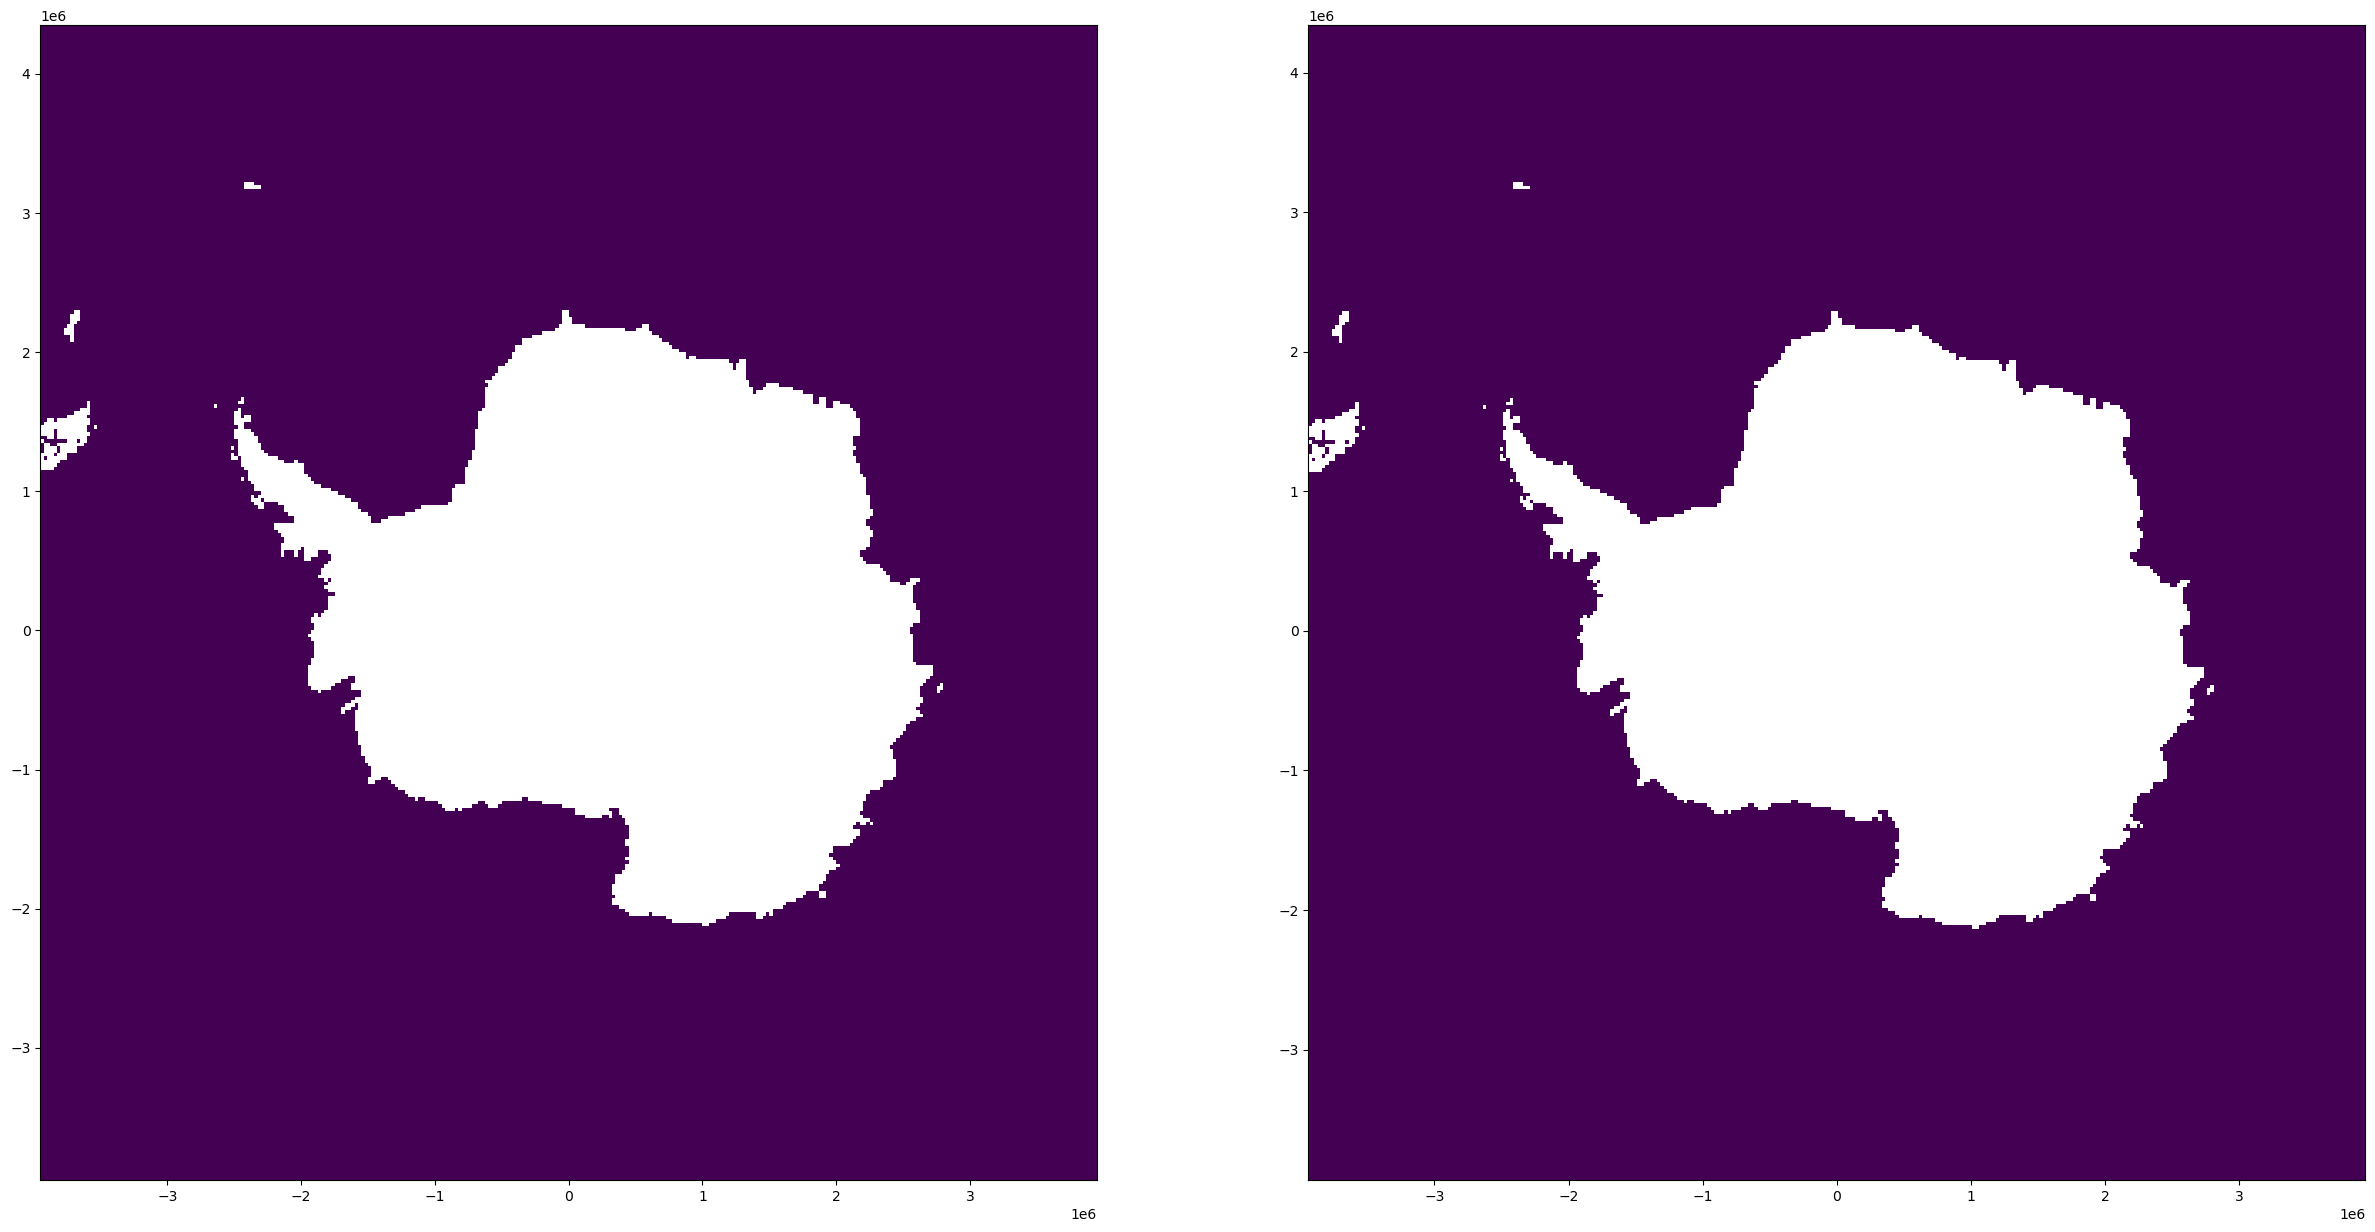

In [40]:
fig, ax = plt.subplots(figsize=(30,15), ncols=2)
ax[0].pcolormesh(xs, ys, ocean_mask)
ax[1].pcolormesh(X, Y, mask)

In [41]:
### Create lat_lon field

latfield = np.zeros((len(Y), len(X)))
lonfield = np.zeros((len(Y), len(X)))

for i in range(len(Y)):
    for j in range(len(X)):
        lat, lon = transformer.transform(X[j], Y[i])
        latfield[i,j] = lat
        lonfield[i,j] = lon

### Get Monthly Mean SEA ICE CONCENTRATION 

In [47]:
files[123], files[151], files[304], files[335]

('S_20060201_concentration_v3.0.tif',
 'S_20060301_concentration_v3.0.tif',
 'S_20060801_concentration_v3.0.tif',
 'S_20060901_concentration_v3.0.tif')

In [48]:
### Get Feb Mean and Aug Mean 
summer_files = files[123:151]
winter_files = files[304:335]

In [146]:
### ALTERNATE - FOR LLC4320 

path = '/Volumes/workDrive/Sea_Ice/1d_tif'
files = [i for i in os.listdir(path) if 'concentration' in i and 'aux' not in i]
files.sort()

summer_files = files[10_500:10_529]
winter_files = files[10_682:10_713]


In [147]:
count = 0 

for i in tqdm(range(len(summer_files))):
    temp = rio.open(f"{path}/{summer_files[i]}")
    temp = temp.read(1)
    temp = temp.astype(float)
    temp[temp>1000] = np.nan
    temp = temp * ocean_mask

    if count == 0:
        summer = temp.copy()
    else:
        summer += temp

    count += 1

summer = summer / count 
summer = summer /1000

Summer = np.zeros((len(Y), len(X)))
countx = 0
county = 0

for i in range(2,len(Y), 5):
    for j in range(2,len(X), 5):
        try:
            Summer[i-2:i+3, j-2:j+3] = summer[county, countx] 
        except:
            print(county, countx)
        countx += 1
    county += 1
    countx = 0

100%|████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 27.55it/s]


In [148]:
count = 0 

for i in tqdm(range(len(winter_files))):
    temp = rio.open(f"{path}/{winter_files[i]}")
    temp = temp.read(1)
    temp = temp.astype(float)
    temp[temp>1000] = np.nan
    temp = temp * ocean_mask

    if count == 0:
        winter = temp.copy()
    else:
        winter += temp

    count += 1

winter = winter / count 
winter = winter / 1000

Winter = np.zeros((len(Y), len(X)))
countx = 0
county = 0

for i in range(2,len(Y), 5):
    for j in range(2,len(X), 5):
        try:
            Winter[i-2:i+3, j-2:j+3] = winter[county, countx] 
        except:
            print(county, countx)
        countx += 1
    county += 1
    countx = 0

100%|████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 25.89it/s]


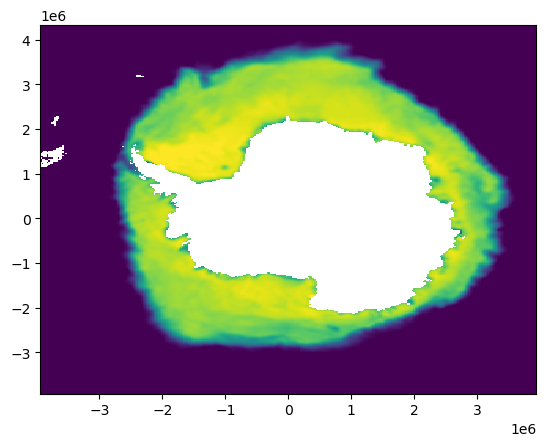

In [149]:
plt.pcolormesh(X, Y, Winter)

In [113]:
np.save('pickle_Maps/X.npy', X)
np.save('pickle_Maps/Y.npy', Y)
np.save('pickle_Maps/lat.npy', latfield)
np.save('pickle_Maps/lon.npy', lonfield)
np.save('pickle_Maps/NSIDC_Summer.npy', Summer)
np.save('pickle_Maps/NSIDC_WInter.npy', Winter)

In [150]:
np.save('pickle_Maps/NSIDC_Summer_ALT.npy', Summer)
np.save('pickle_Maps/NSIDC_WInter_ALT.npy', Winter)

### Map SOhi to Grid

In [30]:
def remap(data, data_x, data_y, target_lon, target_lat, mask=mask):

    res = np.zeros(target_lon.shape) 
    assert np.max(data_x) < 181

    for i in tqdm(range(res.shape[0])):
        for j in range(res.shape[1]):
            lat = target_lat[i,j]
            lon = target_lon[i,j]

            if mask is not None:
                if np.isnan(mask[i,j]):
                    continue
            else:
                pass
                
            if data_x.ndim == 2:
                i1 = (data_x - lon)**2
                i2 = (data_y - lat)**2
                i3 = i1 + i2
                where = np.where(i3 == i3.min())
                iy = where[0][0]
                ix = where[1][0]
            else:
                iy = np.argmin(abs(data_y - lat))
                ix = np.argmin(abs(data_x - lon)) 

            res[i,j] = data[iy, ix]

    return res

In [51]:
path = '/Volumes/workDrive/SIO_Backup/Data/Models/SOHI/2D'
files = ['2D_2006_02C.nc', '2D_2006_08C.nc']

In [130]:
res = []

for f in files:
    cube = nc.Dataset(f"{path}/{f}")
    XC = cube['lon'][:]
    YC = cube['lat'][:]

    temp = cube['SIarea'][:]
    temp = temp.mean(axis=0)

    res.append(remap(temp, XC, YC, lonfield, latfield))

100%|████████████████████████████████████████████████████| 1655/1655 [02:50<00:00,  9.73it/s]


In [31]:
### Make SOhi boundary mask 
SOhi_mask = np.zeros(latfield.shape)

for i in range(latfield.shape[0]):
    for j in range(latfield.shape[1]):
        if latfield[i,j] < -55:
            SOhi_mask[i,j] = 1
SOhi_mask[SOhi_mask==0] = np.nan

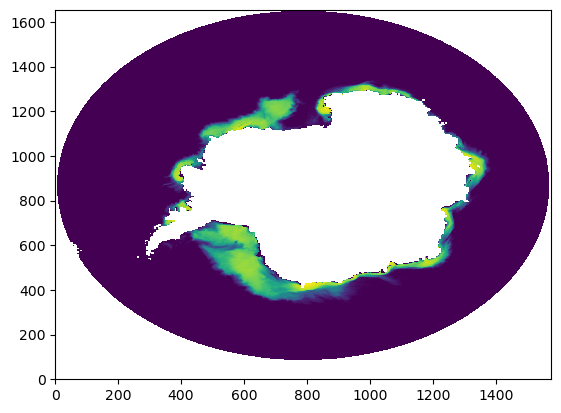

In [138]:
plt.pcolormesh(res[0]*mask*SOhi_mask)

In [139]:
np.save('pickle_Maps/SOhi_Summer', res[0]*mask*SOhi_mask)
np.save('pickle_Maps/SOhi_Winter', res[1]*mask*SOhi_mask)

In [35]:
ICE = h5py.File('/Volumes/workDrive/SIO_Backup/Data/Models/SOHI/meta/ICEDRAFT_v8.mat')
ICE = ICE['Ice_Map'][:2344, :]

In [17]:
ICE = remap(ICE, XC, YC, lonfield, latfield, mask=None)

100%|████████████████████████████████████████████████████| 1655/1655 [03:24<00:00,  8.10it/s]


In [49]:
BATH = h5py.File('/Volumes/workDrive/SIO_Backup/Data/Models/SOHI/meta/GRID_v8.mat')
BATH = -BATH['Depth'][:2344,:]
BATH = BATH + ICE

In [58]:
BATH = remap(BATH, XC, YC, lonfield, latfield, mask=None)

100%|████████████████████████████████████████████████████| 1655/1655 [03:25<00:00,  8.07it/s]


In [23]:
np.save('pickle_Maps/ICE.npy', ICE)
np.save('pickle_Maps/BATH.npy', BATH * SOhi_mask)
np.save('pickle_Maps/OCEAN_MASK.npy', mask)
np.save('pickle_Maps/LATFIELD.npy', latfield)
np.save('pickle_Maps/LONFIELD.npy', lonfield)
np.save('pickle_Maps/XDIM.npy', X)
np.save('pickle_Maps/YDIM.npy', Y)


### Map ECCO4 to grid

In [30]:
cube = nc.Dataset('/Volumes/workDrive/Models/ECCO/ECCO4_SIarea.nc')
XC = cube['lon'][:]
YC = cube['lat'][:]

In [31]:
ECCO_Summer = cube['SIarea'][13][:]
ECCO_Winter = cube['SIarea'][19][:]

In [32]:
import pyresample

In [33]:
og_def = pyresample.geometry.SwathDefinition(lons=XC, lats=YC)

In [34]:
target_def = pyresample.geometry.AreaDefinition(area_id = 'SI_south',
                                                description = 'Sea Ice Polar Stereographic South', 
                                                proj_id = 'SI_south',
                                                projection = 'EPSG:3412',
                                                width = 1576,
                                                height = 1655,
                                                area_extent = (-3937500.0, -3937500.0, 3937500.0, 4337500.0))

In [35]:
result = pyresample.kd_tree.resample_nearest(og_def, ECCO_Summer, target_def, radius_of_influence=50000, nprocs=6)
result2 = pyresample.kd_tree.resample_nearest(og_def, ECCO_Winter, target_def, radius_of_influence=50000, nprocs=6)

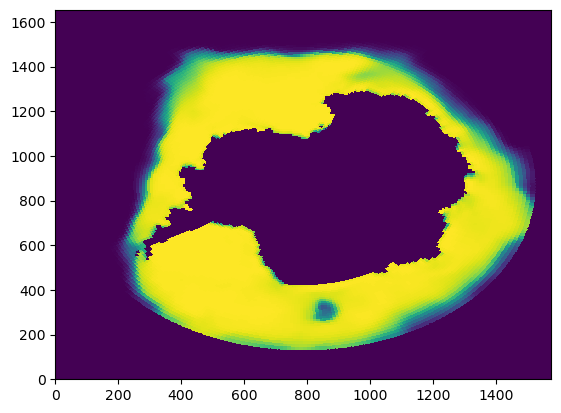

In [36]:
plt.pcolormesh(result2)

In [49]:
ECCO_mask = np.zeros(latfield.shape)

for i in range(latfield.shape[0]):
    for j in range(latfield.shape[1]):
        if latfield[i,j] < -57.2:
            ECCO_mask[i,j] = 1
ECCO_mask[ECCO_mask==0] = np.nan

In [50]:
np.save('pickle_Maps/ECCO_Summer', result*mask*ECCO_mask)
np.save('pickle_Maps/ECCO_Winter', result2*mask*ECCO_mask)

### Map SOSE to grid

In [247]:
path = '/Volumes/workDrive/Models/SOSE/SI/SI_mat'
files = [i for i in os.listdir(path) if '.mat' in i]
files.sort()
files.pop()
files

['274.mat',
 '275.mat',
 '276.mat',
 '277.mat',
 '278.mat',
 '279.mat',
 '280.mat',
 '281.mat',
 '282.mat',
 '283.mat',
 '284.mat',
 '285.mat',
 '286.mat',
 '287.mat',
 '288.mat',
 '289.mat',
 '290.mat',
 '291.mat',
 '292.mat',
 '293.mat',
 '294.mat',
 '295.mat',
 '296.mat',
 '297.mat',
 '298.mat',
 '299.mat',
 '300.mat',
 '301.mat',
 '302.mat',
 '303.mat',
 '304.mat',
 '305.mat',
 '306.mat',
 '307.mat',
 '308.mat',
 '309.mat',
 '310.mat',
 '311.mat',
 '312.mat',
 '313.mat',
 '314.mat',
 '315.mat',
 '316.mat',
 '317.mat',
 '318.mat',
 '319.mat',
 '320.mat',
 '321.mat',
 '322.mat',
 '323.mat',
 '324.mat',
 '325.mat',
 '326.mat',
 '327.mat',
 '328.mat',
 '329.mat',
 '330.mat',
 '331.mat',
 '332.mat',
 '333.mat',
 '334.mat',
 '335.mat',
 '336.mat',
 '337.mat',
 '338.mat',
 '339.mat',
 '340.mat',
 '341.mat',
 '342.mat',
 '343.mat',
 '344.mat',
 '345.mat',
 '346.mat',
 '347.mat',
 '348.mat',
 '349.mat',
 '350.mat',
 '351.mat',
 '352.mat',
 '353.mat',
 '354.mat',
 '355.mat',
 '356.mat',
 '35

In [270]:
files[122], files[150], files[303], files[334]

('396.mat', '424.mat', '577.mat', '608.mat')

In [251]:
365 + 31 + 28 + 31 + 30 + 31 + 30 + 31, 577 + 31

(577, 608)

In [411]:
grid = loadmat('/Volumes/workDrive/Models/SOSE/meta/grid.mat')
XC = ((grid['XC'][:,0] + 180) % 360) - 180
YC = grid['YC'][0,:]

In [271]:
count = 0
SOSE_Summer = None
for f in files[122:151]:
    temp = loadmat(f"{path}/{f}")
    temp = np.swapaxes(temp['SI'][:], 0, 1)
    
    if SOSE_Summer is None:
        SOSE_Summer = temp.copy()
    else:
        SOSE_Summer += temp 
    count += 1
    
SOSE_Summer = SOSE_Summer/count 

count = 0
SOSE_Winter = None
for f in files[304:335]:
    temp = loadmat(f"{path}/{f}")
    temp = np.swapaxes(temp['SI'][:], 0, 1)
    if SOSE_Winter is None:
        SOSE_Winter = temp.copy()
    else:
        SOSE_Winter += temp 
    count += 1
SOSE_Winter = SOSE_Winter/count 

In [274]:
SOSE_Summer = remap(SOSE_Summer, XC, YC, lonfield, latfield)
SOSE_Winter = remap(SOSE_Winter, XC, YC, lonfield, latfield)

100%|████████████████████████████████████████████████████| 1655/1655 [00:22<00:00, 74.52it/s]


In [275]:
### Make SOSE boundary mask 
SOSE_mask = np.zeros(latfield.shape)

for i in range(latfield.shape[0]):
    for j in range(latfield.shape[1]):
        if latfield[i,j] < -55:
            SOSE_mask[i,j] = 1
SOSE_mask[SOSE_mask==0] = np.nan

In [277]:
np.save('pickle_Maps/SOSE_Summer', SOSE_Summer*mask*SOSE_mask)
np.save('pickle_Maps/SOSE_Winter', SOSE_Winter*mask*SOSE_mask)

### Map LLC4320 to Grid

In [283]:
data = zarr.open('/Volumes/workDrive/Models/LLC4320/SI.zarr', 'r')

In [295]:
XC = np.load('/Volumes/workDrive/SIO_Backup/Data/Models/LLC4320/meta/XC.npy')
XC = XC[:-1, :]
YC = np.load('/Volumes/workDrive/SIO_Backup/Data/Models/LLC4320/meta/YC.npy')
YC = YC[:-1,:]

In [287]:
LLC_Summer = None 
count = 0
for t in tqdm(range(122,152)):
    SI = data['SIarea'][t, :, :]
    if LLC_Summer is None:
        LLC_Summer = SI.copy()
    else:
        LLC_Summer += SI
    count += 1
LLC_Summer = LLC_Summer / count 

100%|████████████████████████████████████████████████████████| 30/30 [00:18<00:00,  1.64it/s]


In [288]:
LLC_Winter = None 
count = 0
for t in tqdm(range(305,336)):
    SI = data['SIarea'][t, :, :]
    if LLC_Winter is None:
        LLC_Winter = SI.copy()
    else:
        LLC_Winter += SI
    count += 1
LLC_Winter = LLC_Winter / count 

100%|████████████████████████████████████████████████████████| 31/31 [00:22<00:00,  1.37it/s]


In [289]:
### Make LLC boundary mask 
LLC_mask = np.zeros(latfield.shape)

for i in range(latfield.shape[0]):
    for j in range(latfield.shape[1]):
        if latfield[i,j] < -55:
            LLC_mask[i,j] = 1
LLC_mask[LLC_mask==0] = np.nan

In [309]:
import pyresample

In [350]:
og_def = pyresample.geometry.SwathDefinition(lons=XC, lats=YC)

In [365]:
target_def = pyresample.geometry.AreaDefinition(area_id = 'SI_south',
                                                description = 'Sea Ice Polar Stereographic South', 
                                                proj_id = 'SI_south',
                                                projection = 'EPSG:3412',
                                                width = 1576,
                                                height = 1655,
                                                area_extent = (-3937500.0, -3937500.0, 3937500.0, 4337500.0))

In [371]:
result = pyresample.kd_tree.resample_nearest(og_def, LLC_Summer, target_def, radius_of_influence=5000, nprocs=6)

In [374]:
result2 = pyresample.kd_tree.resample_nearest(og_def, LLC_Winter, target_def, radius_of_influence=5000, nprocs=6)

In [ ]:
LLC_mask = np.zeros(latfield.shape)

for i in range(latfield.shape[0]):
    for j in range(latfield.shape[1]):
        if latfield[i,j] < -55:
            LLC_mask[i,j] = 1
LLC_mask[LLC_mask==0] = np.nan

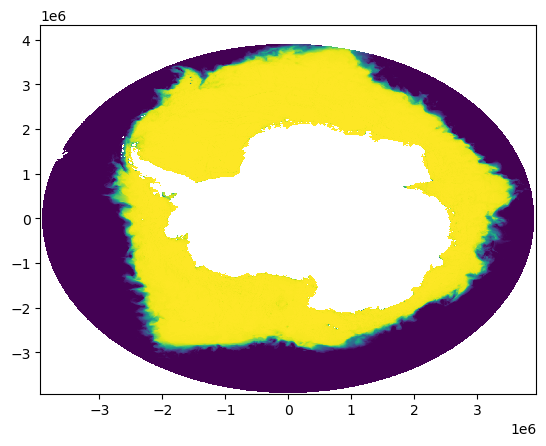

In [376]:
plt.pcolormesh(X, Y, result2*LLC_mask)

In [377]:
np.save('pickle_Maps/LLC_Summer', result*mask*LLC_mask)
np.save('pickle_Maps/LLC_Winter', result2*mask*LLC_mask)

## Make Plot

In [4]:
import matplotlib

In [53]:
Summer = np.load('pickle_Maps/NSIDC_Summer.npy') * ECCO_mask
Winter = np.load('pickle_Maps/NSIDC_Winter.npy') * ECCO_mask


In [54]:
SOhi_Summer = np.load('pickle_Maps/SOhi_Summer.npy')
SOhi_Winter = np.load('pickle_Maps/SOhi_Winter.npy')

dif1 = (SOhi_Summer) - Summer
dif2 = (SOhi_Winter) - Winter

In [55]:
LLC_Summer = np.load('pickle_Maps/LLC_Summer.npy')
LLC_Winter = np.load('pickle_Maps/LLC_Winter.npy')

Alt1 = np.load('pickle_Maps/NSIDC_Summer_ALT.npy')
Alt2 = np.load('pickle_Maps/NSIDC_Winter_ALT.npy')

dif3 = LLC_Summer - Alt1
dif4 = LLC_Winter - Alt2


In [56]:
SOSE_Summer = np.load('pickle_Maps/SOSE_Summer.npy')
SOSE_Winter = np.load('pickle_Maps/SOSE_Winter.npy')

dif5 = SOSE_Summer - Summer
dif6 = SOSE_Winter - Winter


In [57]:
ECCO_Summer = np.load('pickle_Maps/ECCO_Summer.npy')
ECCO_Winter = np.load('pickle_Maps/ECCO_Winter.npy')

dif7 = ECCO_Summer - Summer
dif8 = ECCO_Winter - Winter

In [58]:
ICE = np.load('pickle_Maps/ICE.npy')
ICE[ICE!=0] = 1

BATH = np.load('pickle_Maps/BATH.npy')

### Plot DIF

/var/folders/2n/5cjcyrz92xq2s13y29jhm27w0000gn/T/ipykernel_37695/2648628315.py:17: UserWarning: No contour levels were found within the data range.
  a.contour(X/1000,Y/1000, ICE, levels=[0,1])


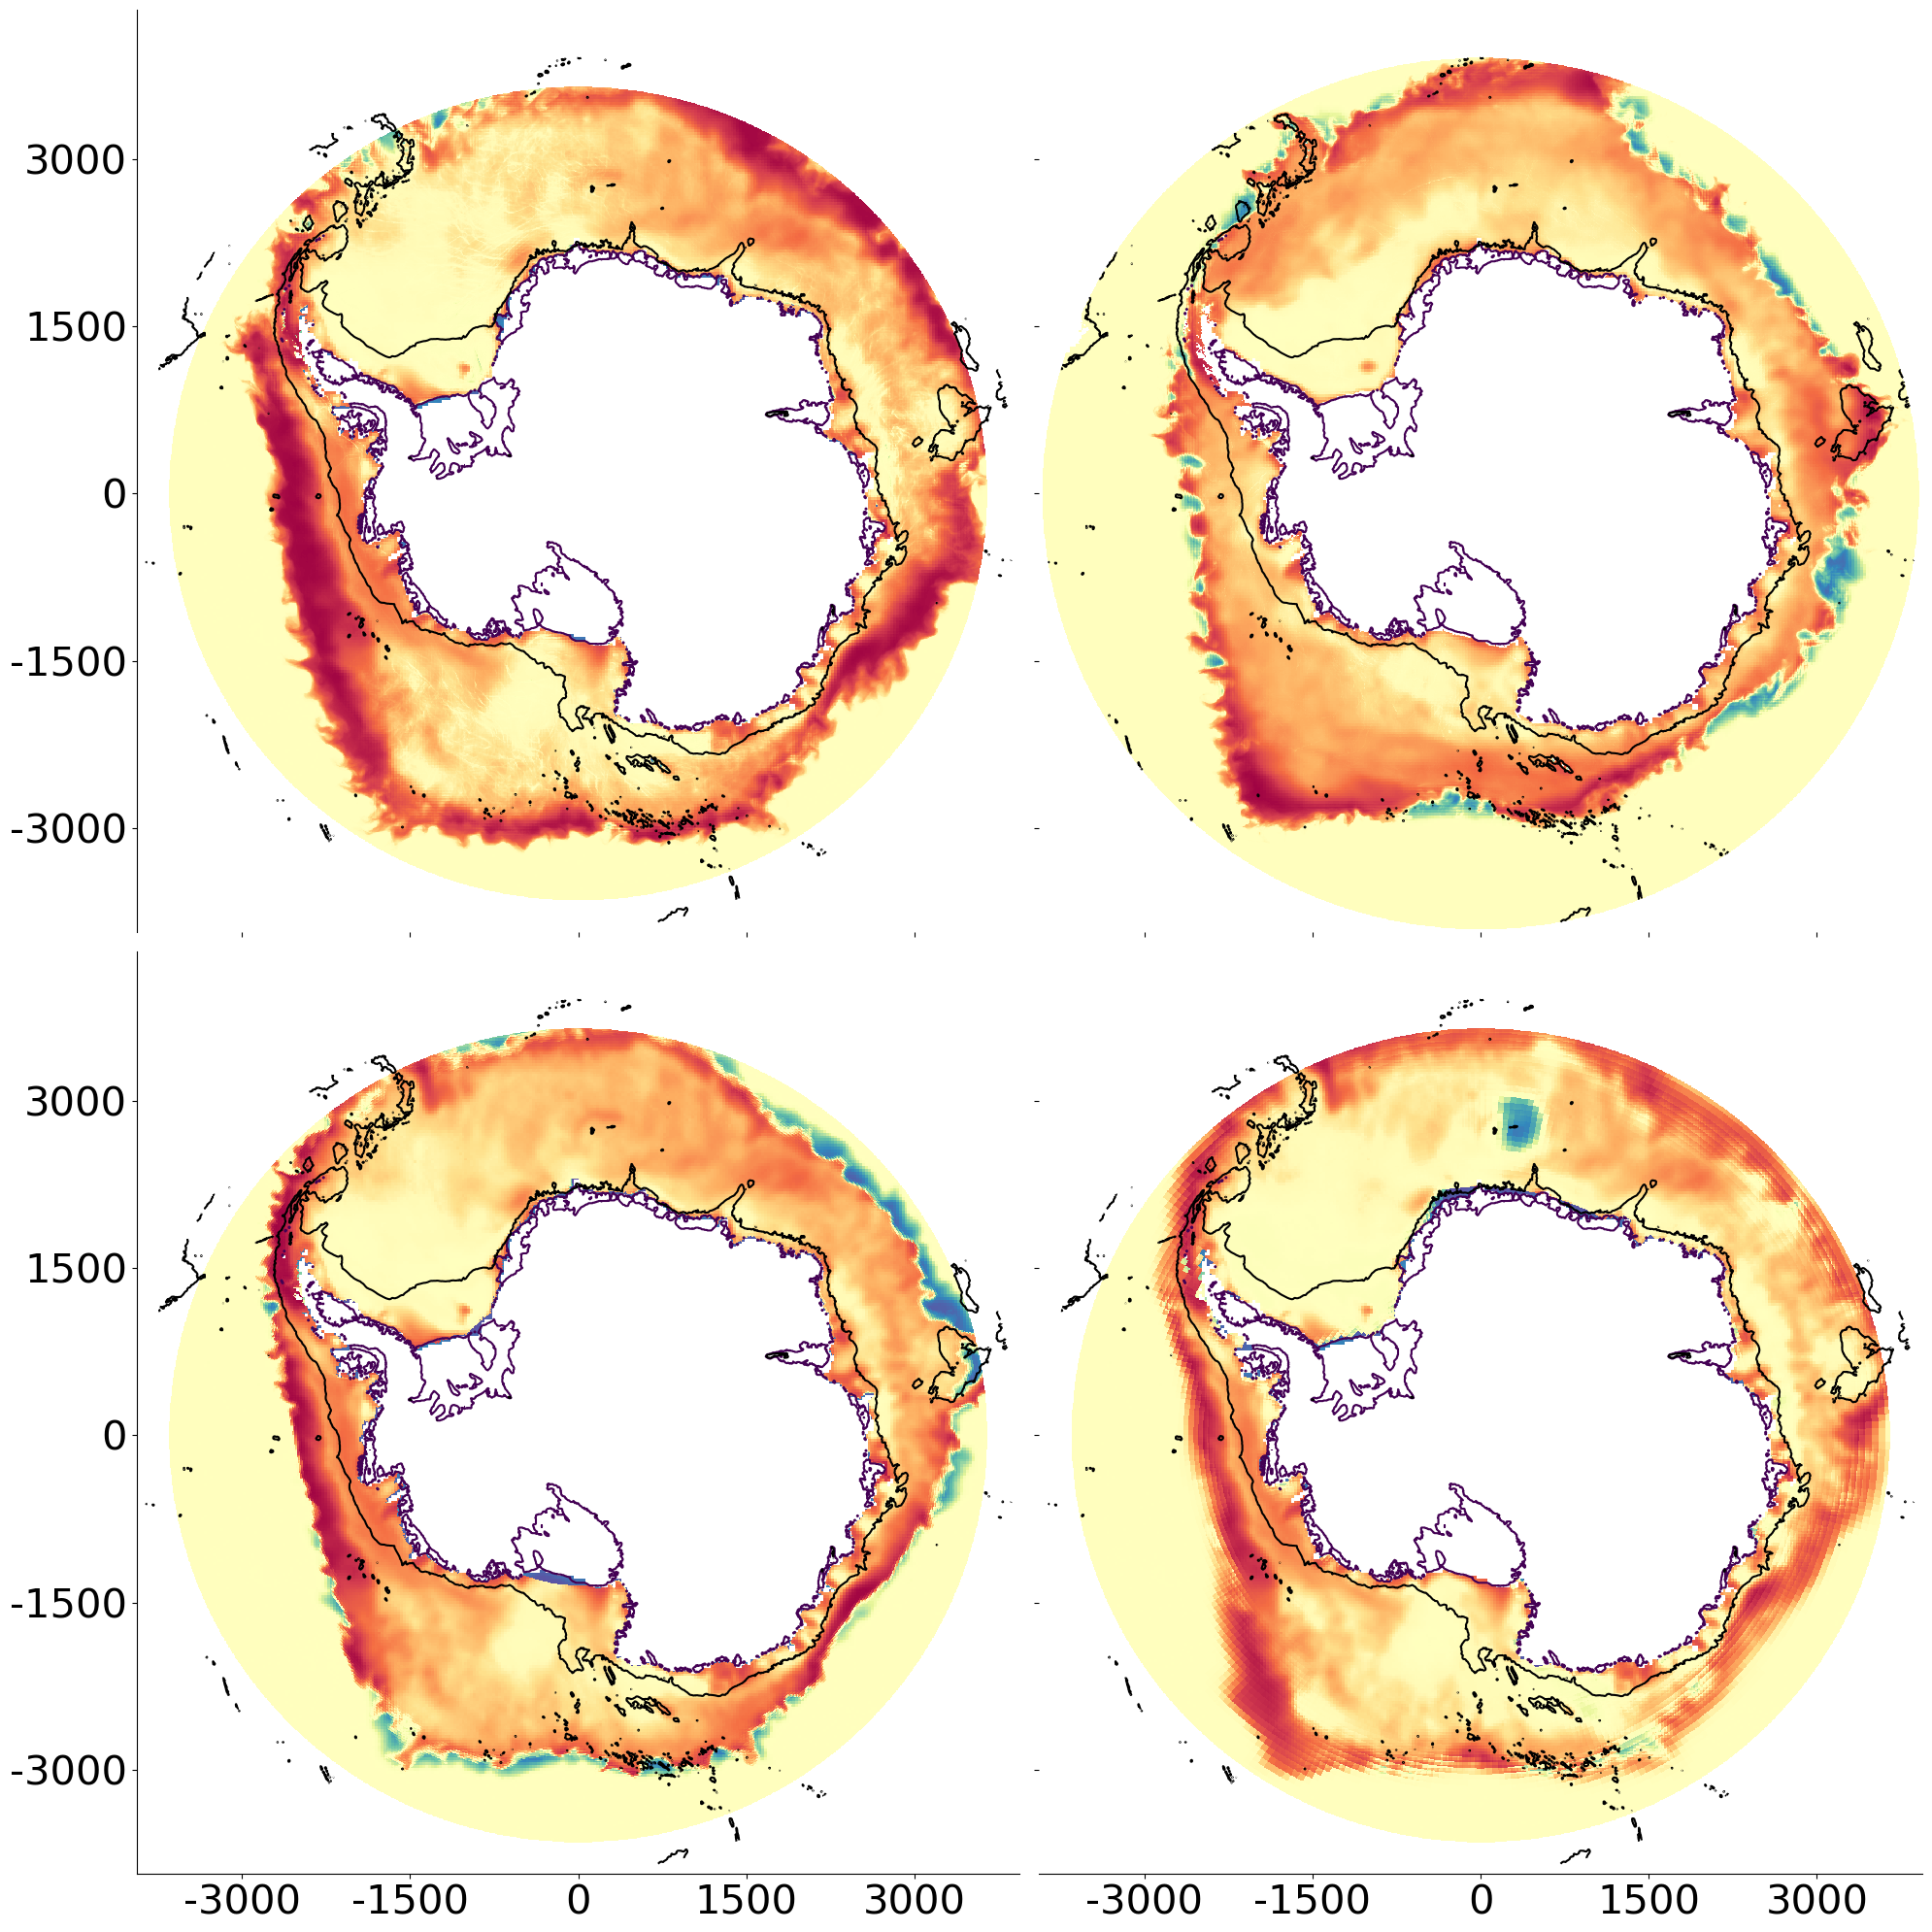

In [59]:
fig, ax = plt.subplots(figsize=(20,20), ncols=2, nrows=2, sharex=True, sharey=True)

norm = matplotlib.colors.SymLogNorm(vmin = -1, vmax = 1, linthresh=0.05, linscale=0.05, clip = False)


im = ax[0,0].pcolormesh(X/1000, Y/1000, dif2, norm=norm, cmap='Spectral_r')
ax[0,1].pcolormesh(X/1000, Y/1000, dif4, norm=norm, cmap='Spectral_r')
ax[1,0].pcolormesh(X/1000, Y/1000, dif6, norm=norm, cmap='Spectral_r')
ax[1,1].pcolormesh(X/1000, Y/1000, dif8, norm=norm, cmap='Spectral_r')


for a in ax.flat:
    a.spines['right'].set_color('none')
    a.spines['top'].set_color('none')
    a.spines['left'].set_color('none')
    a.spines['bottom'].set_color('none')
    a.contour(X/1000,Y/1000, ICE, levels=[0,1])
    a.contour(X/1000,Y/1000, BATH, levels=[-2000], colors=['k'], linestyles='solid')
    a.set_xticks([-3000, -1500, 0, 1500, 3000])
    a.set_xticklabels([-3000, -1500, 0, 1500, 3000])
    a.tick_params(axis='x', labelsize=30)

ax[0,0].spines['left'].set_color('k')
ax[1,0].spines['left'].set_color('k')
ax[1,0].spines['bottom'].set_color('k')
ax[1,1].spines['bottom'].set_color('k')

ax[0,0].set_yticks([-3000, -1500, 0, 1500, 3000])
ax[1,0].set_yticklabels([-3000, -1500, 0, 1500, 3000])
# ax[1].tick_params(axis='y', which='both', length=0)
# ax[2].tick_params(axis='y', which='both', length=0)
# ax[3].tick_params(axis='y', which='both', length=0)

ax[0,0].tick_params(axis='y', labelsize=30)
ax[1,0].tick_params(axis='y', labelsize=30)

# cbar_ax = fig.add_axes([0.20, 0.1, 0.4, 0.04])
# cbar = fig.colorbar(im, cax=cbar_ax,orientation='horizontal', extend='both')
# cbar.ax.set_xlabel(f'Sea Ice Concentration Error (Model - Observation)', size=20)
# cbar.ax.tick_params(labelsize=20)
# cbar.ax.set_xticks([-1, -0.5, 0, 0.5, 1])
# cbar.ax.set_xticklabels([-1, -0.5, 0, 0.5, 1])

plt.tight_layout()

plt.savefig('ALL_Winter_v2.jpg', dpi=300)

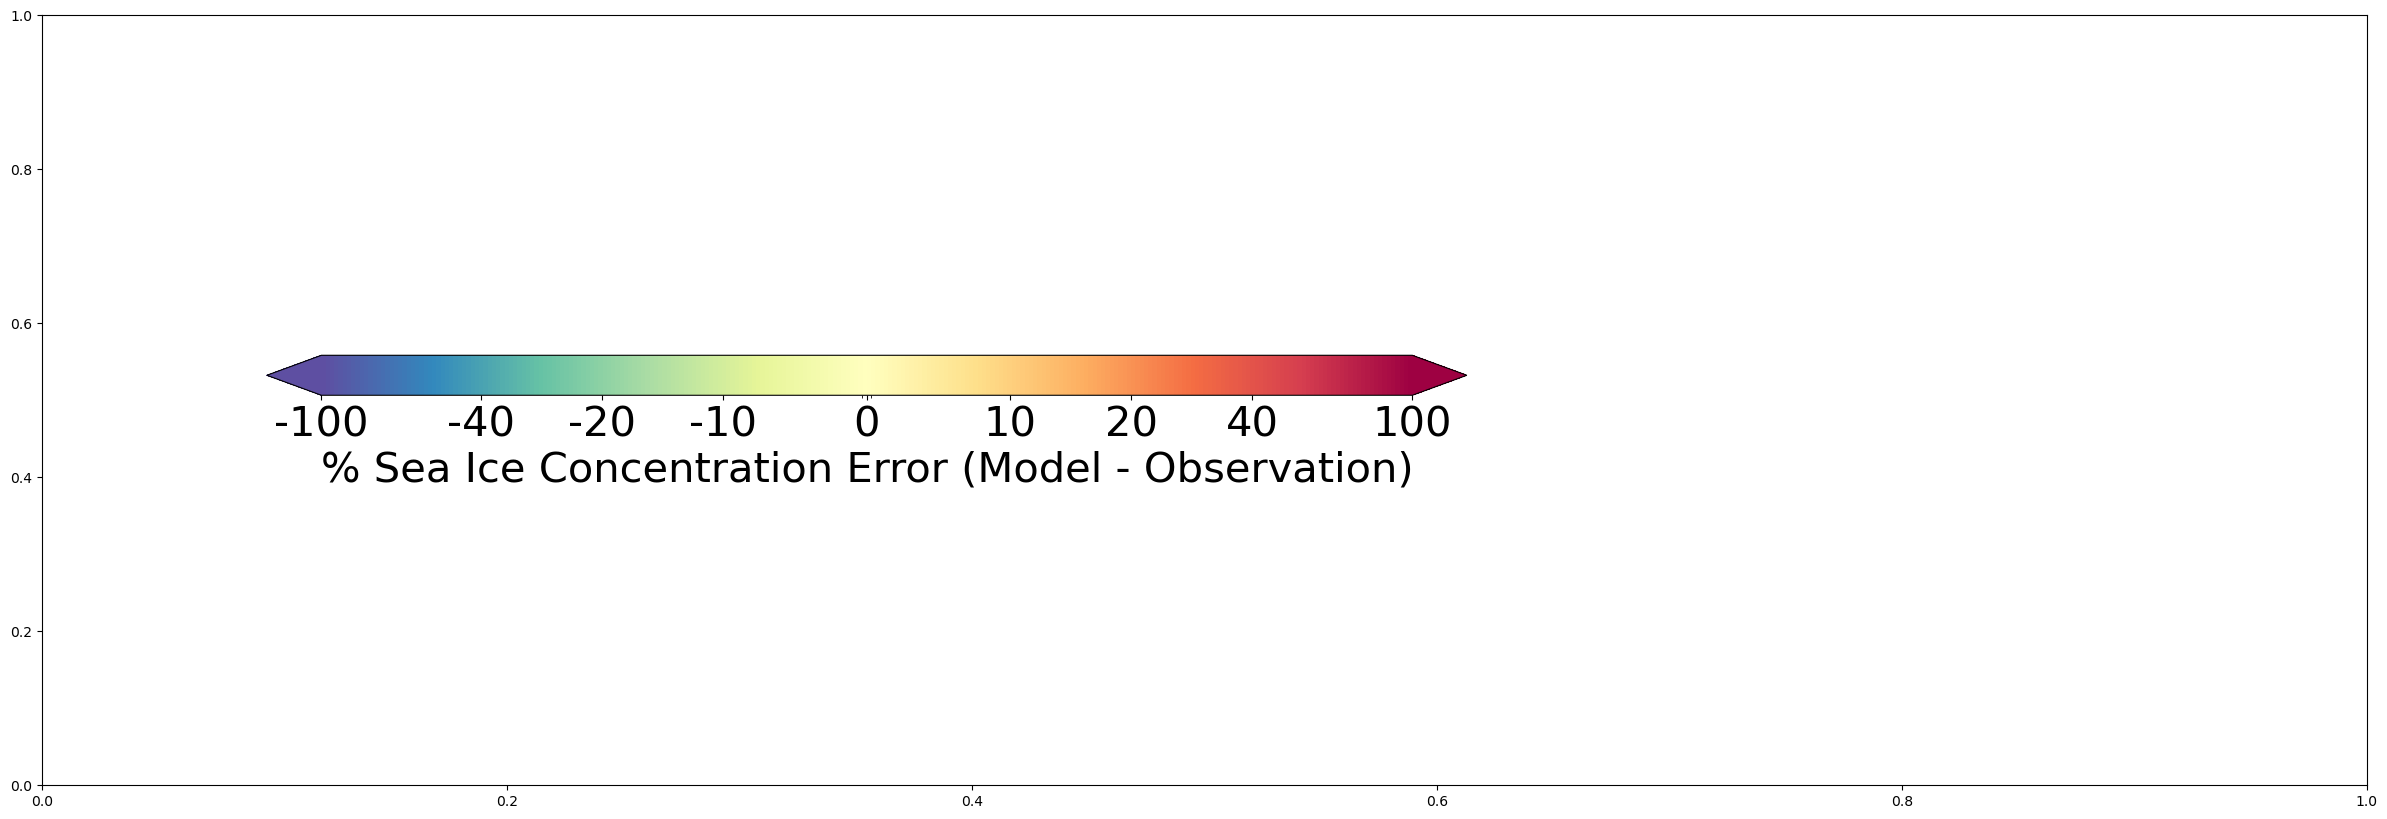

In [29]:
fig, ax = plt.subplots(figsize=(30,10))
cbar_ax = fig.add_axes([0.20, 0.5, 0.4, 0.04])
cbar = fig.colorbar(im, cax=cbar_ax,orientation='horizontal', extend='both')
cbar.ax.set_xlabel(f'% Sea Ice Concentration Error (Model - Observation)', size=30)
cbar.ax.tick_params(labelsize=30)
ticks = [-1,  -0.4, -0.20, -0.1, 0, 0.1, 0.20, 0.4, 1]
cbar.ax.set_xticks(ticks)
cbar.ax.set_xticklabels([int(i) for i in np.asarray(ticks)*100])

plt.savefig('ALL_Winter_cb_v2.jpg', dpi=300)

/var/folders/2n/5cjcyrz92xq2s13y29jhm27w0000gn/T/ipykernel_37695/204834188.py:14: UserWarning: No contour levels were found within the data range.
  a.contour(X/1000,Y/1000, ICE, levels=[0,1])


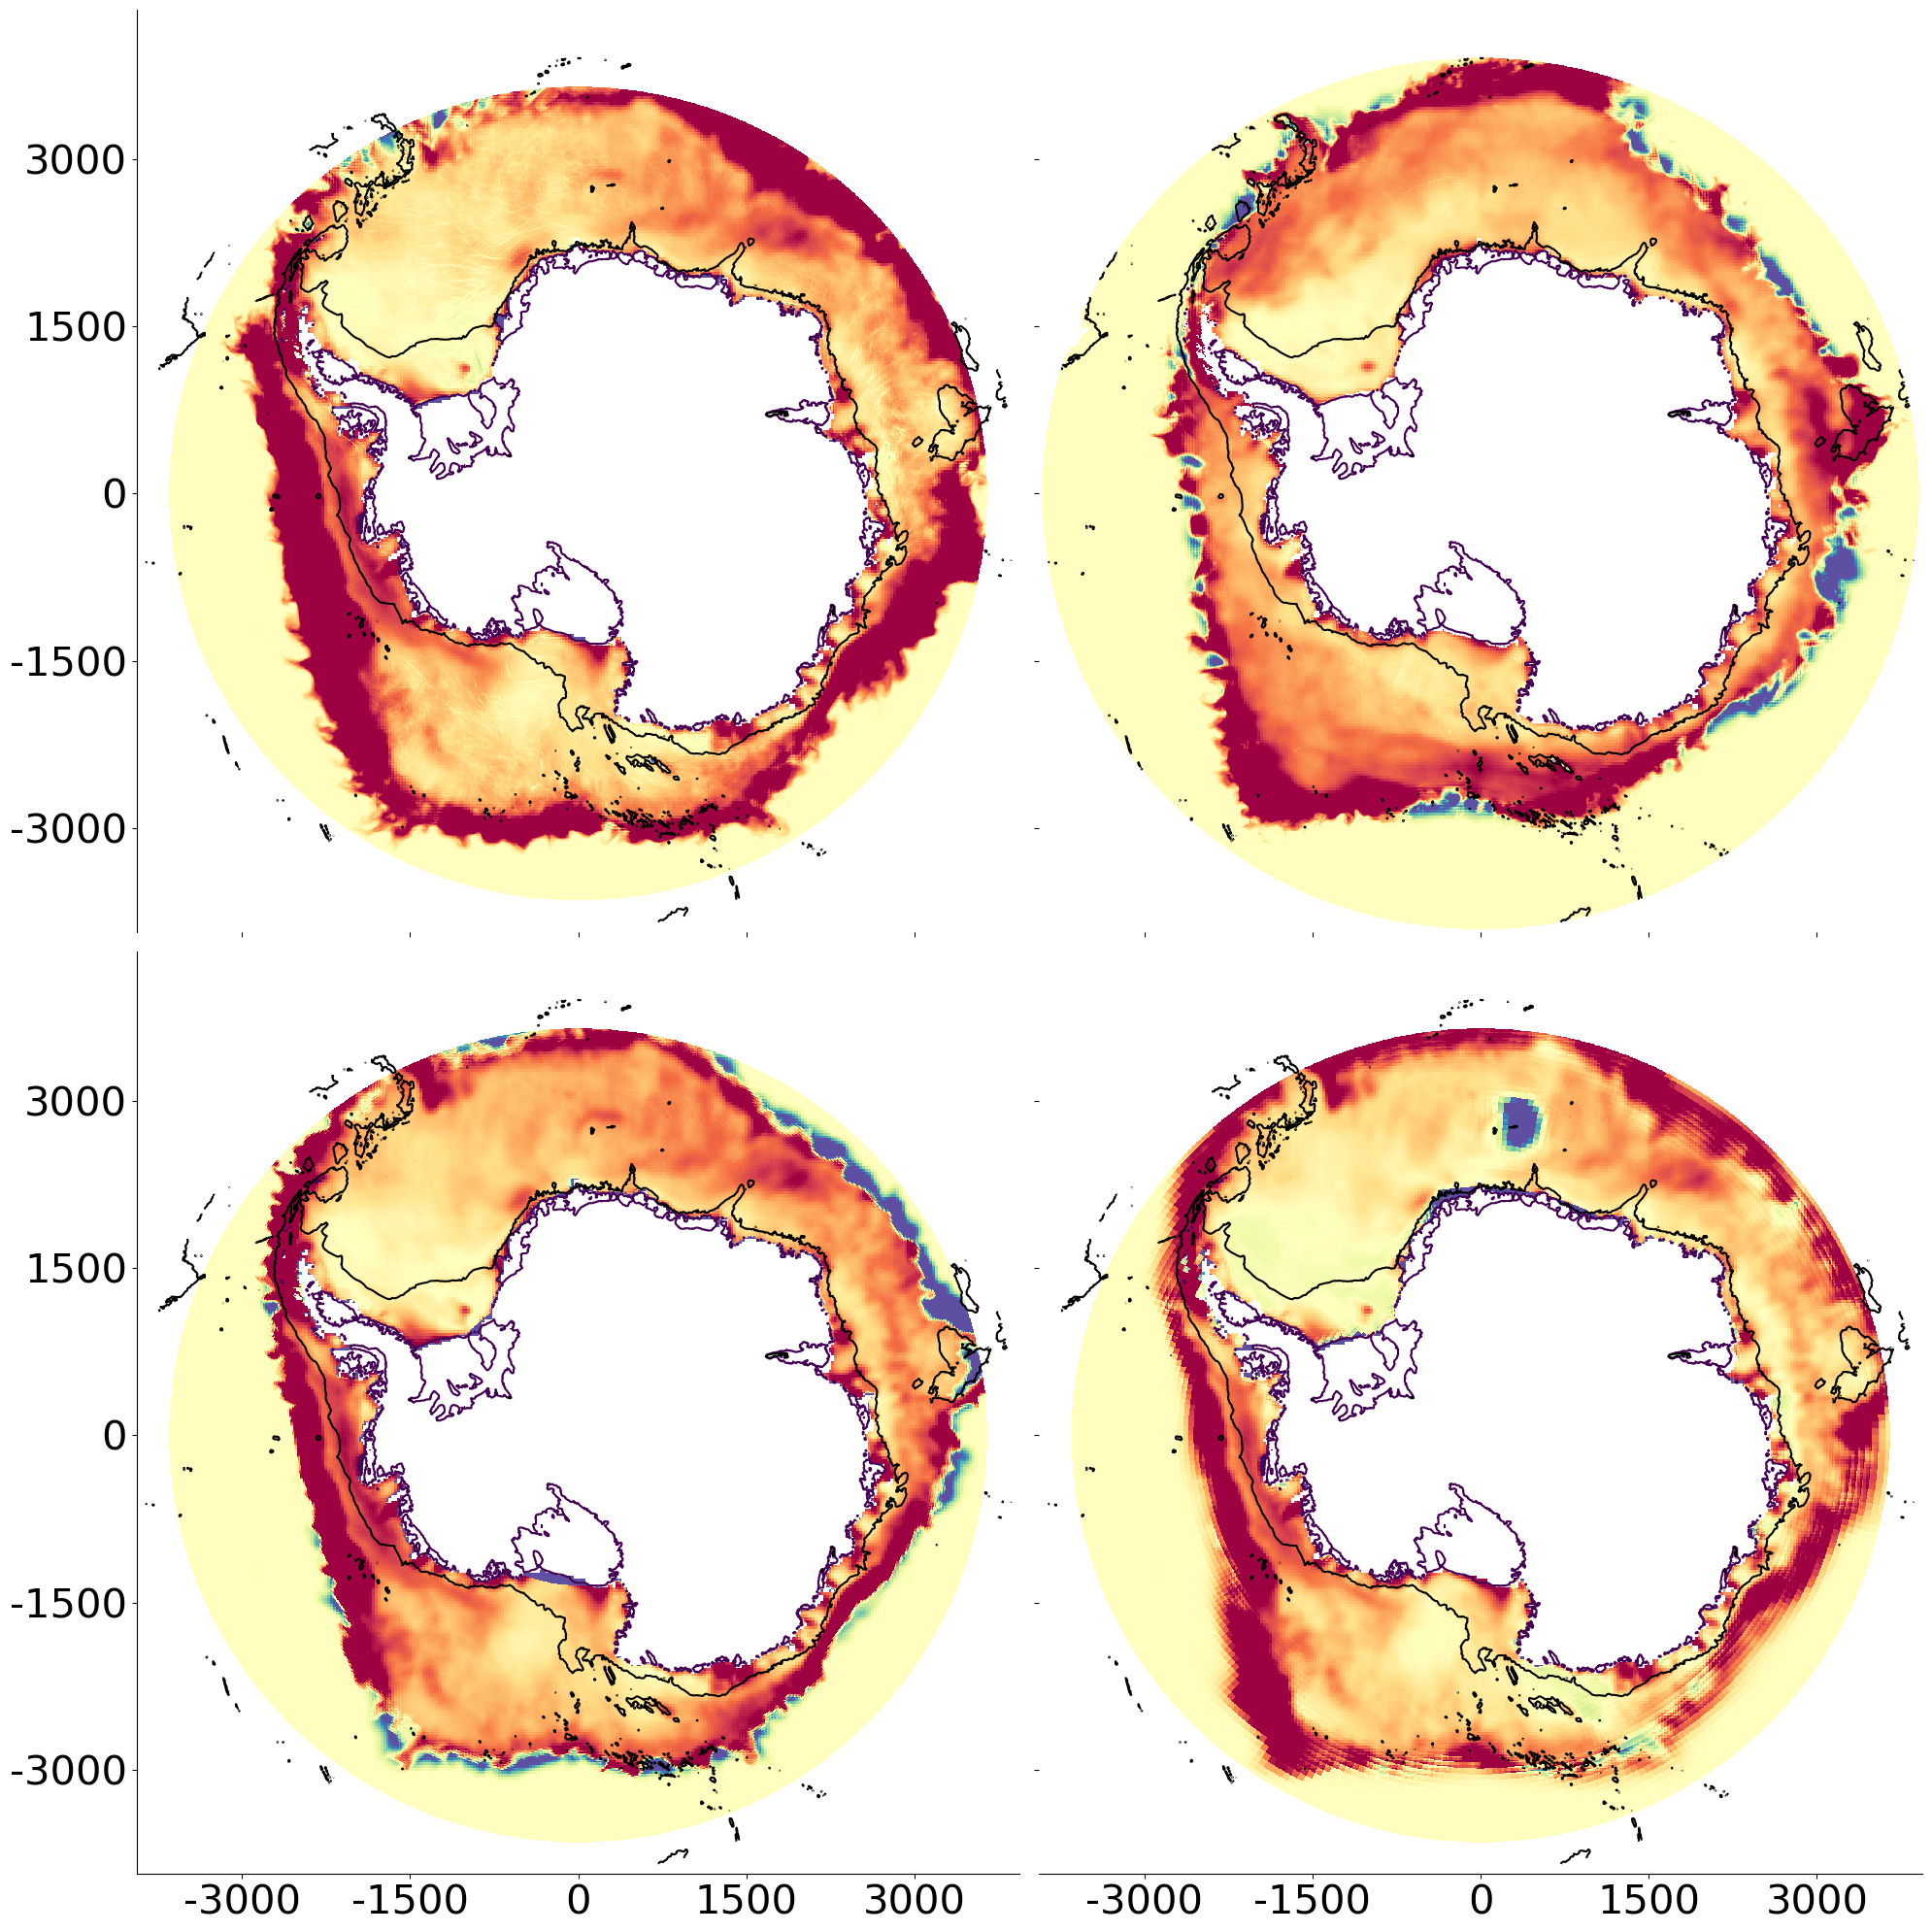

In [60]:
fig, ax = plt.subplots(figsize=(20,20), ncols=2, nrows=2, sharex=True, sharey=True)

im = ax[0,0].pcolormesh(X/1000, Y/1000, dif2, vmin=-0.3, vmax=0.3, cmap='Spectral_r')
ax[0,1].pcolormesh(X/1000, Y/1000, dif4, vmin=-0.3, vmax=0.3, cmap='Spectral_r')
ax[1,0].pcolormesh(X/1000, Y/1000, dif6, vmin=-0.3, vmax=0.3, cmap='Spectral_r')
ax[1,1].pcolormesh(X/1000, Y/1000, dif8, vmin=-0.3, vmax=0.3, cmap='Spectral_r')


for a in ax.flat:
    a.spines['right'].set_color('none')
    a.spines['top'].set_color('none')
    a.spines['left'].set_color('none')
    a.spines['bottom'].set_color('none')
    a.contour(X/1000,Y/1000, ICE, levels=[0,1])
    a.contour(X/1000,Y/1000, BATH, levels=[-2000], colors=['k'], linestyles='solid')
    a.set_xticks([-3000, -1500, 0, 1500, 3000])
    a.set_xticklabels([-3000, -1500, 0, 1500, 3000])
    a.tick_params(axis='x', labelsize=30)

ax[0,0].spines['left'].set_color('k')
ax[1,0].spines['left'].set_color('k')
ax[1,0].spines['bottom'].set_color('k')
ax[1,1].spines['bottom'].set_color('k')

ax[0,0].set_yticks([-3000, -1500, 0, 1500, 3000])
ax[1,0].set_yticklabels([-3000, -1500, 0, 1500, 3000])
# ax[1].tick_params(axis='y', which='both', length=0)
# ax[2].tick_params(axis='y', which='both', length=0)
# ax[3].tick_params(axis='y', which='both', length=0)

ax[0,0].tick_params(axis='y', labelsize=30)
ax[1,0].tick_params(axis='y', labelsize=30)

# cbar_ax = fig.add_axes([0.20, 0.1, 0.4, 0.04])
# cbar = fig.colorbar(im, cax=cbar_ax,orientation='horizontal', extend='both')
# cbar.ax.set_xlabel(f'Sea Ice Concentration Error (Model - Observation)', size=20)
# cbar.ax.tick_params(labelsize=20)
# cbar.ax.set_xticks([-1, -0.5, 0, 0.5, 1])
# cbar.ax.set_xticklabels([-1, -0.5, 0, 0.5, 1])

plt.tight_layout()

plt.savefig('ALL_Winter.jpg', dpi=300)

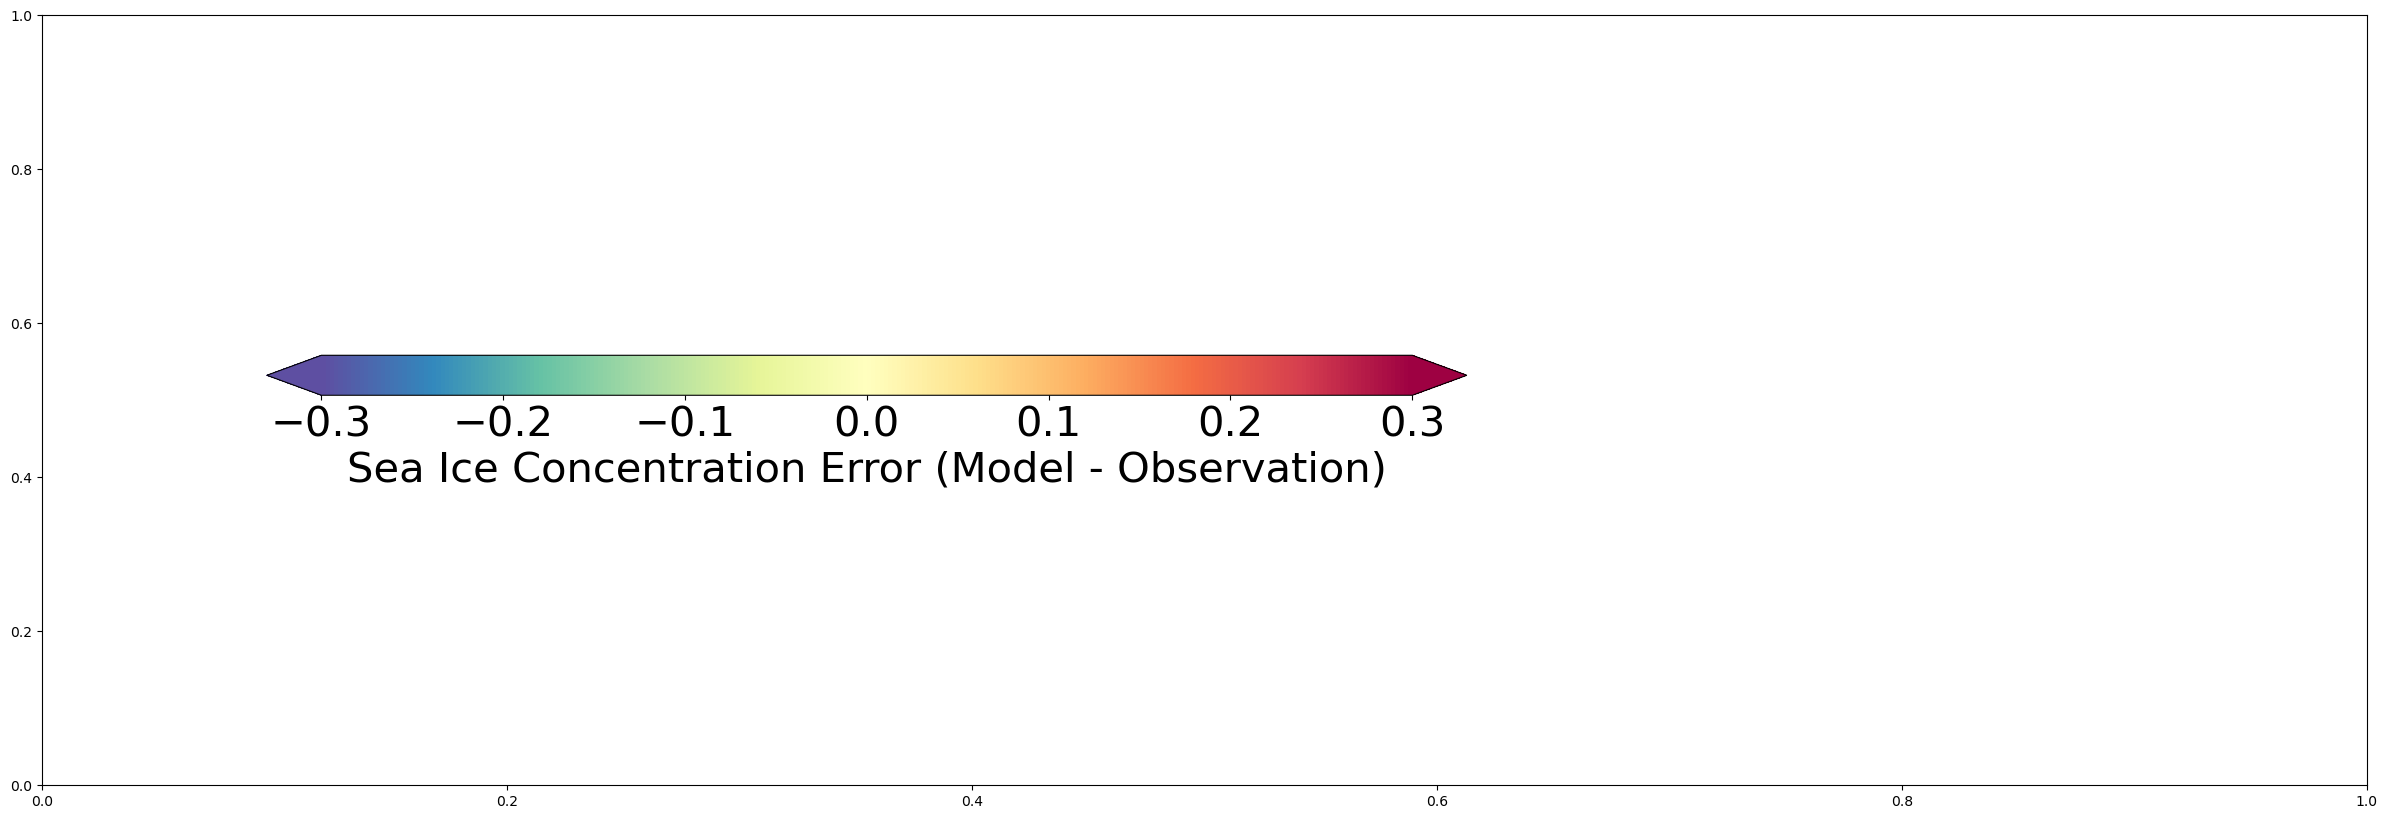

In [61]:
fig, ax = plt.subplots(figsize=(30,10))
cbar_ax = fig.add_axes([0.20, 0.5, 0.4, 0.04])
cbar = fig.colorbar(im, cax=cbar_ax,orientation='horizontal', extend='both')
cbar.ax.set_xlabel(f'Sea Ice Concentration Error (Model - Observation)', size=30)
cbar.ax.tick_params(labelsize=30)
# ticks = [-1,  -0.20, -0.05, 0, 0.05, 0.20, 1]
# cbar.ax.set_xticks(ticks)
# cbar.ax.set_xticklabels([int(i) for i in np.asarray(ticks)*100])

plt.savefig('ALL_Winter_cb.jpg', dpi=300)